In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file('ds', origin='aug_dataset/')
data_dir = pathlib.Path('dataset/')

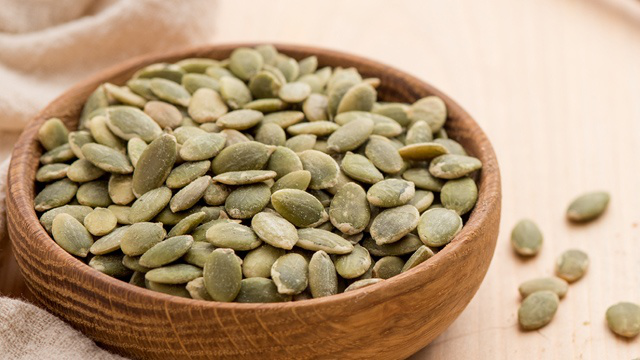

In [4]:
c_A= list(data_dir.glob('A/*'))
PIL.Image.open(str(c_A[0]))

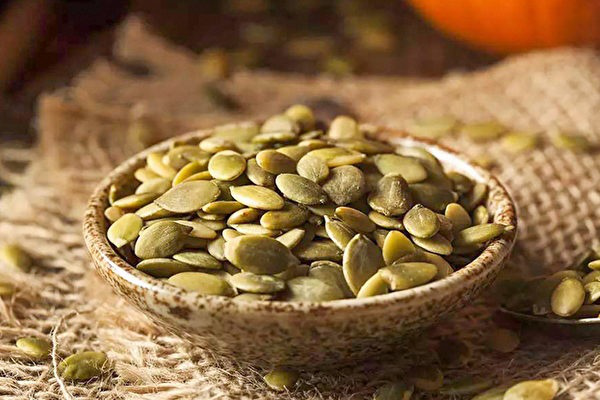

In [5]:
PIL.Image.open(str(c_A[1]))

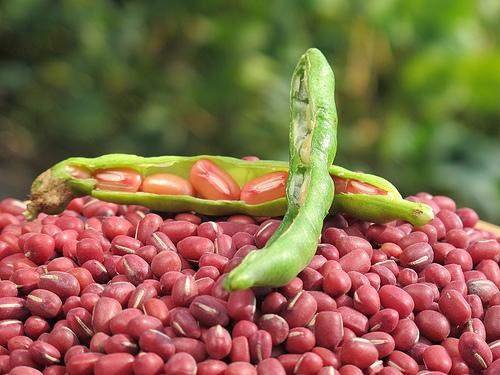

In [6]:
c_B = list(data_dir.glob('B/*'))
PIL.Image.open(str(c_B[0]))

In [7]:
batch_size = 32
img_height = 240
img_width = 240

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=15,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 328 files belonging to 6 classes.
Using 263 files for training.


In [25]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=15,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 328 files belonging to 6 classes.
Using 65 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F']


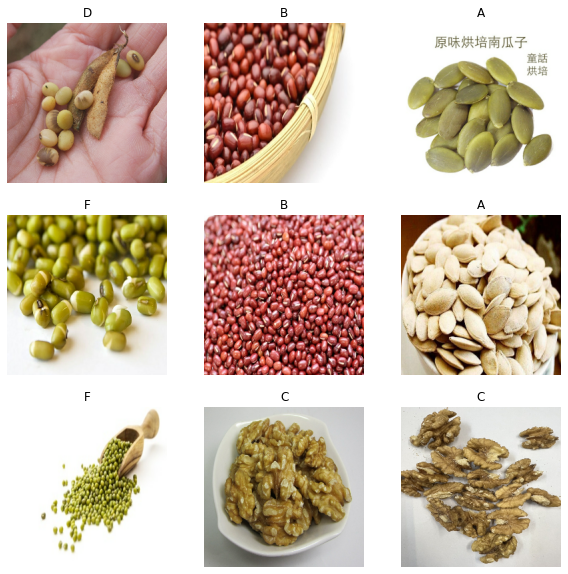

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 240, 240, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


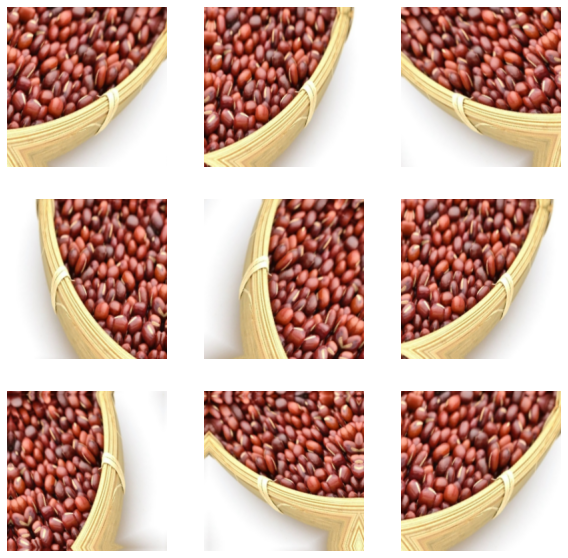

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                  

In [20]:
epochs=1000
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/1000
9/9 [==============================] - 7s 429ms/step - loss: 4.1605 - accuracy: 0.1749 - val_loss: 1.7892 - val_accuracy: 0.1538
Epoch 2/1000
9/9 [==============================] - 4s 396ms/step - loss: 1.7884 - accuracy: 0.1711 - val_loss: 1.7638 - val_accuracy: 0.2462
Epoch 3/1000
9/9 [==============================] - 4s 390ms/step - loss: 1.7494 - accuracy: 0.2281 - val_loss: 1.8604 - val_accuracy: 0.1385
Epoch 4/1000
9/9 [==============================] - 4s 390ms/step - loss: 1.7058 - accuracy: 0.2738 - val_loss: 1.7683 - val_accuracy: 0.2308
Epoch 5/1000
9/9 [==============================] - 4s 394ms/step - loss: 1.6435 - accuracy: 0.2586 - val_loss: 1.7472 - val_accuracy: 0.2615
Epoch 6/1000
9/9 [==============================] - 4s 386ms/step - loss: 1.5734 - accuracy: 0.3004 - val_loss: 1.8206 - val_accuracy: 0.2615
Epoch 7/1000
9/9 [==============================] - 4s 397ms/step - loss: 1.4946 - accuracy: 0.3232 - val_loss: 1.7915 - val_accuracy: 0.2769
Epoch 

9/9 [==============================] - 3s 383ms/step - loss: 0.4079 - accuracy: 0.8517 - val_loss: 3.0327 - val_accuracy: 0.4154
Epoch 42/1000
9/9 [==============================] - 3s 382ms/step - loss: 0.3723 - accuracy: 0.8745 - val_loss: 3.7836 - val_accuracy: 0.4615
Epoch 43/1000
9/9 [==============================] - 4s 390ms/step - loss: 0.3547 - accuracy: 0.8821 - val_loss: 2.7266 - val_accuracy: 0.4923
Epoch 44/1000
9/9 [==============================] - 3s 384ms/step - loss: 0.3220 - accuracy: 0.8935 - val_loss: 4.2833 - val_accuracy: 0.3846
Epoch 45/1000
9/9 [==============================] - 3s 383ms/step - loss: 0.4312 - accuracy: 0.8707 - val_loss: 2.9542 - val_accuracy: 0.4769
Epoch 46/1000
9/9 [==============================] - 3s 384ms/step - loss: 0.2677 - accuracy: 0.9049 - val_loss: 3.8733 - val_accuracy: 0.4923
Epoch 47/1000
9/9 [==============================] - 3s 383ms/step - loss: 0.2608 - accuracy: 0.9125 - val_loss: 2.9830 - val_accuracy: 0.4462
Epoch 48/1000

9/9 [==============================] - 4s 388ms/step - loss: 0.2584 - accuracy: 0.9049 - val_loss: 3.9582 - val_accuracy: 0.5692
Epoch 99/1000
9/9 [==============================] - 3s 384ms/step - loss: 0.1531 - accuracy: 0.9696 - val_loss: 5.1408 - val_accuracy: 0.4923
Epoch 100/1000
9/9 [==============================] - 3s 382ms/step - loss: 0.1128 - accuracy: 0.9734 - val_loss: 4.6939 - val_accuracy: 0.5538
Epoch 101/1000
9/9 [==============================] - 3s 385ms/step - loss: 0.1464 - accuracy: 0.9658 - val_loss: 5.0740 - val_accuracy: 0.5231
Epoch 102/1000
9/9 [==============================] - 4s 388ms/step - loss: 0.1217 - accuracy: 0.9620 - val_loss: 5.4341 - val_accuracy: 0.5538
Epoch 103/1000
9/9 [==============================] - 3s 422ms/step - loss: 0.1261 - accuracy: 0.9658 - val_loss: 4.0767 - val_accuracy: 0.5692
Epoch 104/1000
9/9 [==============================] - 3s 419ms/step - loss: 0.1626 - accuracy: 0.9468 - val_loss: 3.4467 - val_accuracy: 0.5846
Epoch 10

9/9 [==============================] - 3s 377ms/step - loss: 0.1093 - accuracy: 0.9506 - val_loss: 5.2166 - val_accuracy: 0.5385
Epoch 156/1000
9/9 [==============================] - 3s 377ms/step - loss: 0.0901 - accuracy: 0.9620 - val_loss: 5.5303 - val_accuracy: 0.5692
Epoch 157/1000
9/9 [==============================] - 3s 382ms/step - loss: 0.0687 - accuracy: 0.9734 - val_loss: 5.1122 - val_accuracy: 0.5692
Epoch 158/1000
9/9 [==============================] - 3s 381ms/step - loss: 0.0346 - accuracy: 0.9924 - val_loss: 6.2656 - val_accuracy: 0.5692
Epoch 159/1000
9/9 [==============================] - 3s 374ms/step - loss: 0.0358 - accuracy: 0.9924 - val_loss: 6.0751 - val_accuracy: 0.6000
Epoch 160/1000
9/9 [==============================] - 3s 378ms/step - loss: 0.0188 - accuracy: 0.9962 - val_loss: 5.2937 - val_accuracy: 0.5692
Epoch 161/1000
9/9 [==============================] - 3s 376ms/step - loss: 0.0255 - accuracy: 0.9924 - val_loss: 4.4617 - val_accuracy: 0.5692
Epoch 1

Epoch 212/1000
9/9 [==============================] - 3s 376ms/step - loss: 0.0513 - accuracy: 0.9886 - val_loss: 5.1373 - val_accuracy: 0.6154
Epoch 213/1000
9/9 [==============================] - 3s 383ms/step - loss: 0.0187 - accuracy: 0.9962 - val_loss: 6.7806 - val_accuracy: 0.5846
Epoch 214/1000
9/9 [==============================] - 3s 378ms/step - loss: 0.0246 - accuracy: 0.9924 - val_loss: 5.9699 - val_accuracy: 0.6000
Epoch 215/1000
9/9 [==============================] - 3s 411ms/step - loss: 0.0256 - accuracy: 0.9886 - val_loss: 5.3940 - val_accuracy: 0.6154
Epoch 216/1000
9/9 [==============================] - 3s 374ms/step - loss: 0.0148 - accuracy: 0.9962 - val_loss: 5.4833 - val_accuracy: 0.6154
Epoch 217/1000
9/9 [==============================] - 3s 376ms/step - loss: 0.0245 - accuracy: 0.9886 - val_loss: 5.4136 - val_accuracy: 0.6000
Epoch 218/1000
9/9 [==============================] - 3s 385ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 5.2138 - val_accuracy:

Epoch 269/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.8915 - accuracy: 0.8555 - val_loss: 2.4682 - val_accuracy: 0.4154
Epoch 270/1000
9/9 [==============================] - 3s 381ms/step - loss: 1.1025 - accuracy: 0.6198 - val_loss: 2.3055 - val_accuracy: 0.3692
Epoch 271/1000
9/9 [==============================] - 3s 407ms/step - loss: 0.8947 - accuracy: 0.6426 - val_loss: 2.9107 - val_accuracy: 0.4923
Epoch 272/1000
9/9 [==============================] - 3s 374ms/step - loss: 0.6387 - accuracy: 0.7452 - val_loss: 3.5109 - val_accuracy: 0.5077
Epoch 273/1000
9/9 [==============================] - 3s 373ms/step - loss: 0.3638 - accuracy: 0.9011 - val_loss: 3.4243 - val_accuracy: 0.5538
Epoch 274/1000
9/9 [==============================] - 3s 381ms/step - loss: 0.2877 - accuracy: 0.9087 - val_loss: 3.7708 - val_accuracy: 0.5231
Epoch 275/1000
9/9 [==============================] - 3s 381ms/step - loss: 0.1318 - accuracy: 0.9658 - val_loss: 5.0005 - val_accuracy:

Epoch 326/1000
9/9 [==============================] - 3s 380ms/step - loss: 0.0332 - accuracy: 0.9886 - val_loss: 5.4654 - val_accuracy: 0.6154
Epoch 327/1000
9/9 [==============================] - 3s 372ms/step - loss: 0.0269 - accuracy: 0.9962 - val_loss: 5.8254 - val_accuracy: 0.6154
Epoch 328/1000
9/9 [==============================] - 3s 377ms/step - loss: 0.0185 - accuracy: 0.9962 - val_loss: 6.7467 - val_accuracy: 0.5385
Epoch 329/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.0259 - accuracy: 0.9886 - val_loss: 6.0878 - val_accuracy: 0.6000
Epoch 330/1000
9/9 [==============================] - 3s 382ms/step - loss: 0.0285 - accuracy: 0.9886 - val_loss: 5.5031 - val_accuracy: 0.6462
Epoch 331/1000
9/9 [==============================] - 3s 379ms/step - loss: 0.0394 - accuracy: 0.9886 - val_loss: 5.9859 - val_accuracy: 0.6462
Epoch 332/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.0188 - accuracy: 0.9962 - val_loss: 5.6234 - val_accuracy:

Epoch 383/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.2039 - accuracy: 0.9810 - val_loss: 4.6968 - val_accuracy: 0.5538
Epoch 384/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.1225 - accuracy: 0.9544 - val_loss: 5.5500 - val_accuracy: 0.5077
Epoch 385/1000
9/9 [==============================] - 3s 412ms/step - loss: 0.1363 - accuracy: 0.9506 - val_loss: 4.0604 - val_accuracy: 0.5692
Epoch 386/1000
9/9 [==============================] - 3s 381ms/step - loss: 0.0818 - accuracy: 0.9886 - val_loss: 5.1502 - val_accuracy: 0.5385
Epoch 387/1000
9/9 [==============================] - 3s 382ms/step - loss: 0.0651 - accuracy: 0.9924 - val_loss: 5.7060 - val_accuracy: 0.5538
Epoch 388/1000
9/9 [==============================] - 3s 376ms/step - loss: 0.0178 - accuracy: 0.9924 - val_loss: 6.1977 - val_accuracy: 0.5692
Epoch 389/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.0215 - accuracy: 0.9924 - val_loss: 6.0114 - val_accuracy:

Epoch 440/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.0066 - accuracy: 0.9962 - val_loss: 5.4656 - val_accuracy: 0.6154
Epoch 441/1000
9/9 [==============================] - 3s 377ms/step - loss: 0.0092 - accuracy: 0.9962 - val_loss: 5.5089 - val_accuracy: 0.6154
Epoch 442/1000
9/9 [==============================] - 3s 378ms/step - loss: 0.0070 - accuracy: 0.9962 - val_loss: 5.4602 - val_accuracy: 0.6154
Epoch 443/1000
9/9 [==============================] - 4s 389ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 5.5589 - val_accuracy: 0.6154
Epoch 444/1000
9/9 [==============================] - 3s 381ms/step - loss: 0.0114 - accuracy: 0.9924 - val_loss: 5.6823 - val_accuracy: 0.6154
Epoch 445/1000
9/9 [==============================] - 3s 376ms/step - loss: 0.0111 - accuracy: 0.9962 - val_loss: 5.9461 - val_accuracy: 0.6000
Epoch 446/1000
9/9 [==============================] - 3s 372ms/step - loss: 0.0149 - accuracy: 0.9962 - val_loss: 5.7752 - val_accuracy:

Epoch 497/1000
9/9 [==============================] - 3s 385ms/step - loss: 0.0077 - accuracy: 0.9962 - val_loss: 5.4609 - val_accuracy: 0.6154
Epoch 498/1000
9/9 [==============================] - 4s 394ms/step - loss: 0.0085 - accuracy: 0.9924 - val_loss: 5.4263 - val_accuracy: 0.6308
Epoch 499/1000
9/9 [==============================] - 4s 392ms/step - loss: 0.0106 - accuracy: 0.9924 - val_loss: 5.2549 - val_accuracy: 0.6154
Epoch 500/1000
9/9 [==============================] - 3s 408ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 5.3430 - val_accuracy: 0.6154
Epoch 501/1000
9/9 [==============================] - 3s 368ms/step - loss: 0.0098 - accuracy: 0.9962 - val_loss: 5.3104 - val_accuracy: 0.6308
Epoch 502/1000
9/9 [==============================] - 3s 372ms/step - loss: 0.0108 - accuracy: 0.9962 - val_loss: 5.3532 - val_accuracy: 0.6308
Epoch 503/1000
9/9 [==============================] - 3s 406ms/step - loss: 0.0121 - accuracy: 0.9924 - val_loss: 5.2901 - val_accuracy:

Epoch 554/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.0956 - accuracy: 0.9734 - val_loss: 5.9496 - val_accuracy: 0.5538
Epoch 555/1000
9/9 [==============================] - 3s 386ms/step - loss: 0.0473 - accuracy: 0.9810 - val_loss: 5.4376 - val_accuracy: 0.6000
Epoch 556/1000
9/9 [==============================] - 3s 383ms/step - loss: 0.0508 - accuracy: 0.9848 - val_loss: 4.4348 - val_accuracy: 0.6308
Epoch 557/1000
9/9 [==============================] - 3s 376ms/step - loss: 0.0122 - accuracy: 0.9962 - val_loss: 4.6021 - val_accuracy: 0.6000
Epoch 558/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 4.8947 - val_accuracy: 0.6000
Epoch 559/1000
9/9 [==============================] - 3s 372ms/step - loss: 0.0200 - accuracy: 0.9886 - val_loss: 4.8346 - val_accuracy: 0.6000
Epoch 560/1000
9/9 [==============================] - 4s 389ms/step - loss: 0.0286 - accuracy: 0.9886 - val_loss: 5.8937 - val_accuracy:

Epoch 611/1000
9/9 [==============================] - 3s 377ms/step - loss: 0.0063 - accuracy: 0.9962 - val_loss: 5.4050 - val_accuracy: 0.6615
Epoch 612/1000
9/9 [==============================] - 3s 377ms/step - loss: 0.0098 - accuracy: 0.9924 - val_loss: 5.3786 - val_accuracy: 0.6615
Epoch 613/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.0138 - accuracy: 0.9924 - val_loss: 5.2758 - val_accuracy: 0.6615
Epoch 614/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.0100 - accuracy: 0.9962 - val_loss: 5.4453 - val_accuracy: 0.6615
Epoch 615/1000
9/9 [==============================] - 3s 373ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 5.6508 - val_accuracy: 0.6615
Epoch 616/1000
9/9 [==============================] - 3s 379ms/step - loss: 0.0153 - accuracy: 0.9924 - val_loss: 5.7299 - val_accuracy: 0.6308
Epoch 617/1000
9/9 [==============================] - 3s 383ms/step - loss: 0.0112 - accuracy: 0.9924 - val_loss: 5.7340 - val_accuracy:

Epoch 668/1000
9/9 [==============================] - 3s 385ms/step - loss: 0.0047 - accuracy: 0.9962 - val_loss: 5.7365 - val_accuracy: 0.6462
Epoch 669/1000
9/9 [==============================] - 3s 423ms/step - loss: 0.0044 - accuracy: 0.9962 - val_loss: 5.7458 - val_accuracy: 0.6462
Epoch 670/1000
9/9 [==============================] - 3s 375ms/step - loss: 0.0072 - accuracy: 0.9962 - val_loss: 5.7816 - val_accuracy: 0.6462
Epoch 671/1000
9/9 [==============================] - 3s 408ms/step - loss: 0.0060 - accuracy: 0.9962 - val_loss: 5.9193 - val_accuracy: 0.6462
Epoch 672/1000
9/9 [==============================] - 3s 377ms/step - loss: 0.0085 - accuracy: 0.9962 - val_loss: 5.9983 - val_accuracy: 0.6462
Epoch 673/1000
9/9 [==============================] - 3s 381ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 5.9779 - val_accuracy: 0.6462
Epoch 674/1000
9/9 [==============================] - 3s 372ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 6.0038 - val_accuracy:

Epoch 725/1000
9/9 [==============================] - 3s 379ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 4.7355 - val_accuracy: 0.6615
Epoch 726/1000
9/9 [==============================] - 3s 374ms/step - loss: 0.0106 - accuracy: 0.9924 - val_loss: 4.8649 - val_accuracy: 0.6615
Epoch 727/1000
9/9 [==============================] - 3s 371ms/step - loss: 0.0239 - accuracy: 0.9962 - val_loss: 4.4026 - val_accuracy: 0.6462
Epoch 728/1000
9/9 [==============================] - 3s 373ms/step - loss: 0.0095 - accuracy: 0.9962 - val_loss: 4.0987 - val_accuracy: 0.5846
Epoch 729/1000
9/9 [==============================] - 3s 381ms/step - loss: 0.1157 - accuracy: 0.9886 - val_loss: 4.3007 - val_accuracy: 0.6308
Epoch 730/1000
9/9 [==============================] - 3s 377ms/step - loss: 0.0177 - accuracy: 0.9924 - val_loss: 4.9949 - val_accuracy: 0.6462
Epoch 731/1000
9/9 [==============================] - 3s 373ms/step - loss: 0.0190 - accuracy: 0.9886 - val_loss: 5.2818 - val_accuracy:

Epoch 782/1000
9/9 [==============================] - 3s 412ms/step - loss: 0.0064 - accuracy: 0.9962 - val_loss: 5.8962 - val_accuracy: 0.6000
Epoch 783/1000
9/9 [==============================] - 3s 373ms/step - loss: 0.0057 - accuracy: 0.9962 - val_loss: 5.9832 - val_accuracy: 0.6000
Epoch 784/1000
9/9 [==============================] - 3s 376ms/step - loss: 0.0063 - accuracy: 0.9962 - val_loss: 5.9193 - val_accuracy: 0.6000
Epoch 785/1000
9/9 [==============================] - 3s 379ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 5.7754 - val_accuracy: 0.6000
Epoch 786/1000
9/9 [==============================] - 3s 379ms/step - loss: 0.0199 - accuracy: 0.9924 - val_loss: 6.6642 - val_accuracy: 0.5846
Epoch 787/1000
9/9 [==============================] - 3s 377ms/step - loss: 0.0259 - accuracy: 0.9886 - val_loss: 6.5145 - val_accuracy: 0.5692
Epoch 788/1000
9/9 [==============================] - 3s 377ms/step - loss: 0.0065 - accuracy: 0.9962 - val_loss: 5.5700 - val_accuracy:

Epoch 839/1000
9/9 [==============================] - 3s 373ms/step - loss: 0.0067 - accuracy: 0.9962 - val_loss: 5.7639 - val_accuracy: 0.6154
Epoch 840/1000
9/9 [==============================] - 3s 373ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 5.7697 - val_accuracy: 0.6154
Epoch 841/1000
9/9 [==============================] - 3s 411ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 5.8178 - val_accuracy: 0.6000
Epoch 842/1000
9/9 [==============================] - 3s 383ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 5.8919 - val_accuracy: 0.6000
Epoch 843/1000
9/9 [==============================] - 3s 377ms/step - loss: 0.0062 - accuracy: 0.9962 - val_loss: 5.9095 - val_accuracy: 0.6154
Epoch 844/1000
9/9 [==============================] - 3s 372ms/step - loss: 0.0056 - accuracy: 0.9962 - val_loss: 5.8974 - val_accuracy: 0.6154
Epoch 845/1000
9/9 [==============================] - 3s 373ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 5.9225 - val_accuracy:

Epoch 896/1000
9/9 [==============================] - 3s 373ms/step - loss: 0.0050 - accuracy: 0.9962 - val_loss: 5.6579 - val_accuracy: 0.6154
Epoch 897/1000
9/9 [==============================] - 3s 402ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 5.7475 - val_accuracy: 0.6154
Epoch 898/1000
9/9 [==============================] - 3s 377ms/step - loss: 0.0058 - accuracy: 0.9924 - val_loss: 5.7818 - val_accuracy: 0.6154
Epoch 899/1000
9/9 [==============================] - 3s 382ms/step - loss: 0.0080 - accuracy: 0.9962 - val_loss: 5.7847 - val_accuracy: 0.6154
Epoch 900/1000
9/9 [==============================] - 3s 401ms/step - loss: 0.0083 - accuracy: 0.9962 - val_loss: 5.6143 - val_accuracy: 0.6308
Epoch 901/1000
9/9 [==============================] - 3s 369ms/step - loss: 0.0067 - accuracy: 0.9924 - val_loss: 5.5266 - val_accuracy: 0.6308
Epoch 902/1000
9/9 [==============================] - 3s 370ms/step - loss: 0.0082 - accuracy: 0.9924 - val_loss: 5.4744 - val_accuracy:

Epoch 953/1000
9/9 [==============================] - 3s 416ms/step - loss: 0.0128 - accuracy: 0.9962 - val_loss: 6.2114 - val_accuracy: 0.5846
Epoch 954/1000
9/9 [==============================] - 3s 381ms/step - loss: 0.0184 - accuracy: 0.9924 - val_loss: 5.7449 - val_accuracy: 0.6154
Epoch 955/1000
9/9 [==============================] - 3s 387ms/step - loss: 0.0083 - accuracy: 0.9962 - val_loss: 5.1767 - val_accuracy: 0.6462
Epoch 956/1000
9/9 [==============================] - 3s 418ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 5.2556 - val_accuracy: 0.6308
Epoch 957/1000
9/9 [==============================] - 4s 397ms/step - loss: 0.0079 - accuracy: 0.9962 - val_loss: 5.5835 - val_accuracy: 0.6154
Epoch 958/1000
9/9 [==============================] - 3s 382ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 5.8289 - val_accuracy: 0.6154
Epoch 959/1000
9/9 [==============================] - 3s 420ms/step - loss: 0.0107 - accuracy: 0.9924 - val_loss: 5.7474 - val_accuracy:

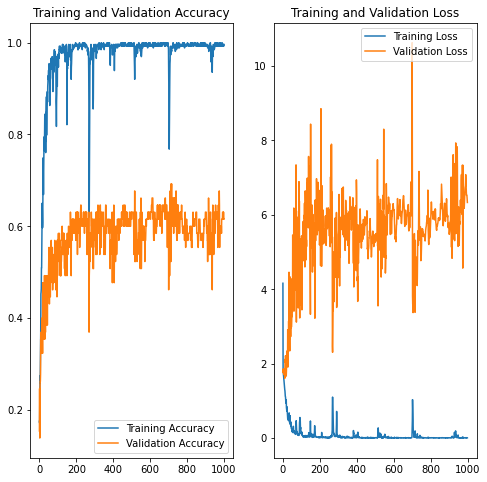

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
file_path = "pictures/20210608234308483.jpg"
#pimg_path = tf.keras.utils.get_file('Red_sunflower', origin=file_path)

img = tf.keras.utils.load_img(
    file_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step
This image most likely belongs to D with a 100.00 percent confidence.


In [43]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  'val_ds/',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=1)

NotFoundError: Could not find directory val_ds/

In [44]:
loss, acc = model.evaluate(test_ds, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

NameError: name 'test_ds' is not defined

In [45]:
model.save('corns')

INFO:tensorflow:Assets written to: corns\assets


INFO:tensorflow:Assets written to: corns\assets


In [ ]:
new_model = tf.keras.models.load_model('corns')